In [2]:
import seaborn as sns
from software.data_collector import get_data_for_period
from software.data_processor import process_data
from software.backtester import run_back_test
from software.plotter import plot_bollinger_bands, plot_ema_and_sma, plot_rsi, plot_atr, plot_signals
from software.strategy import Strategy
from software.tasks import execute_trades
from software.analysis import evaluate_performance

%matplotlib inline
sns.set_style('darkgrid')

ticker = "BTC-USD"
start_date = "2024-11-02 20:00:00"
end_date = "2024-11-04 01:30:00"
interval = "1m"

sma_period=5
ema_period=20
rsi_period=7
bbands_period=20
atr_period=14

initial_cash = 1000
transaction_cost = 0.001
leverage=1
slippage_pct=0.0005
risk_per_trade=0.02

data = get_data_for_period(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
processed_data = process_data(
    data,
    sma_period=sma_period,
    ema_period=ema_period,
    rsi_period=rsi_period,
    bbands_period=bbands_period,
    atr_period=atr_period,
)

strategy = Strategy(
    ema_sma_threshold=0,
    rsi_long_threshold=40,
    rsi_short_threshold=60,
    bb_threshold=0,
)


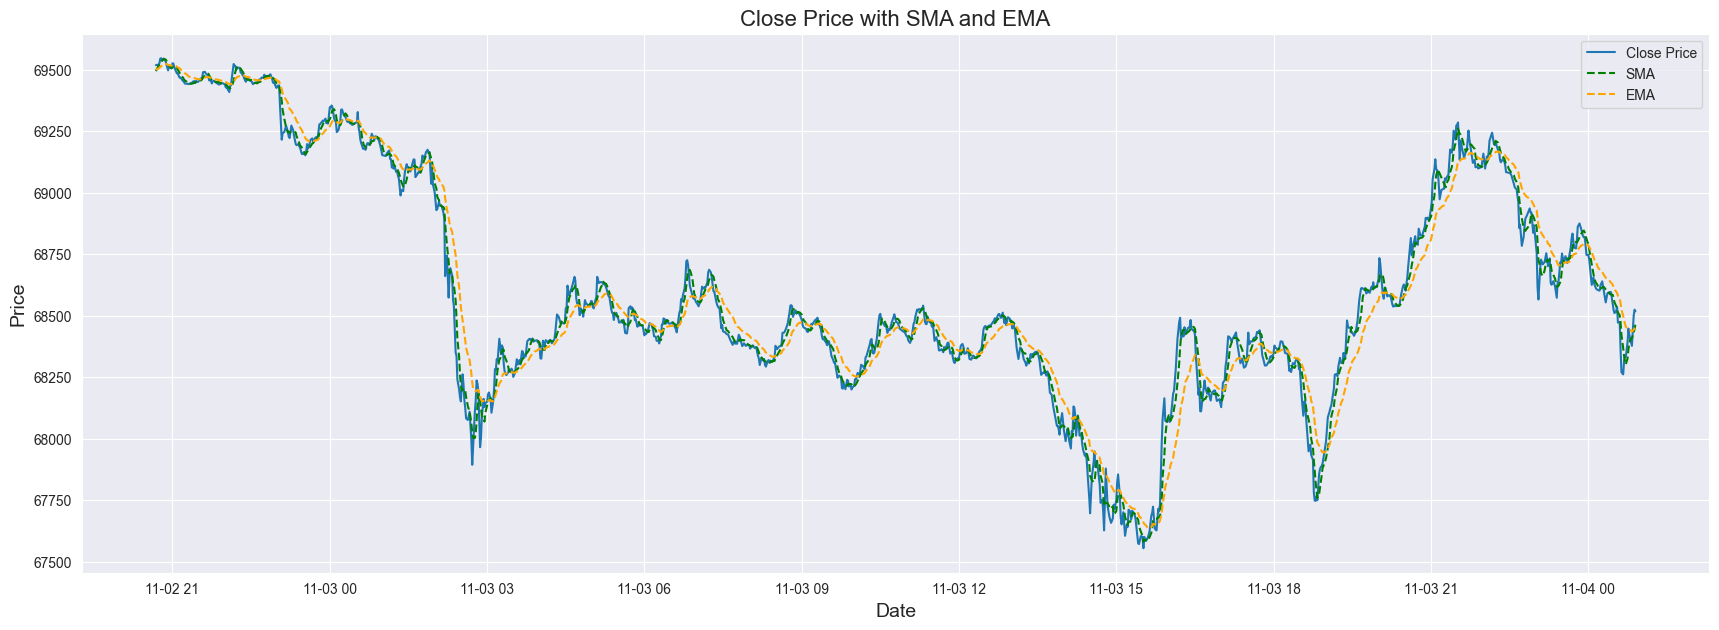

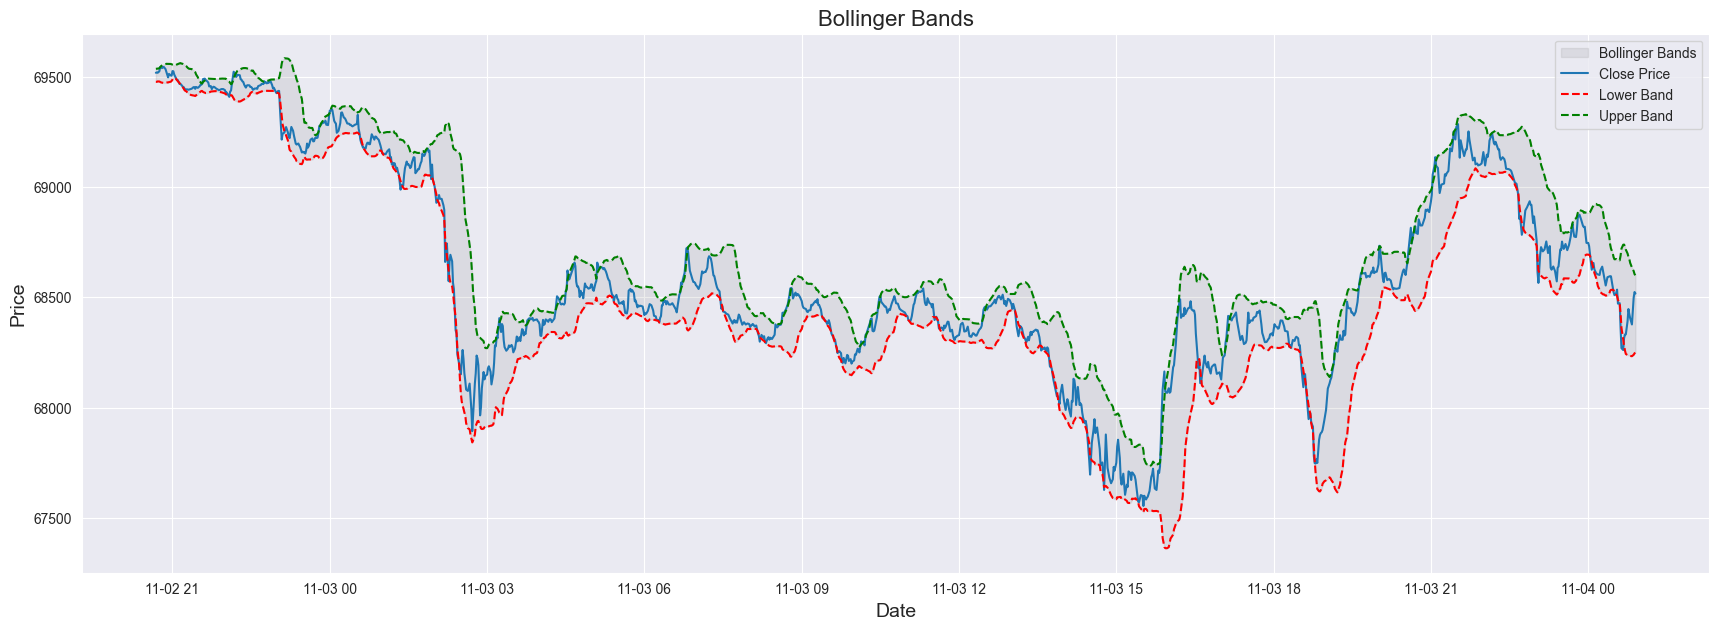

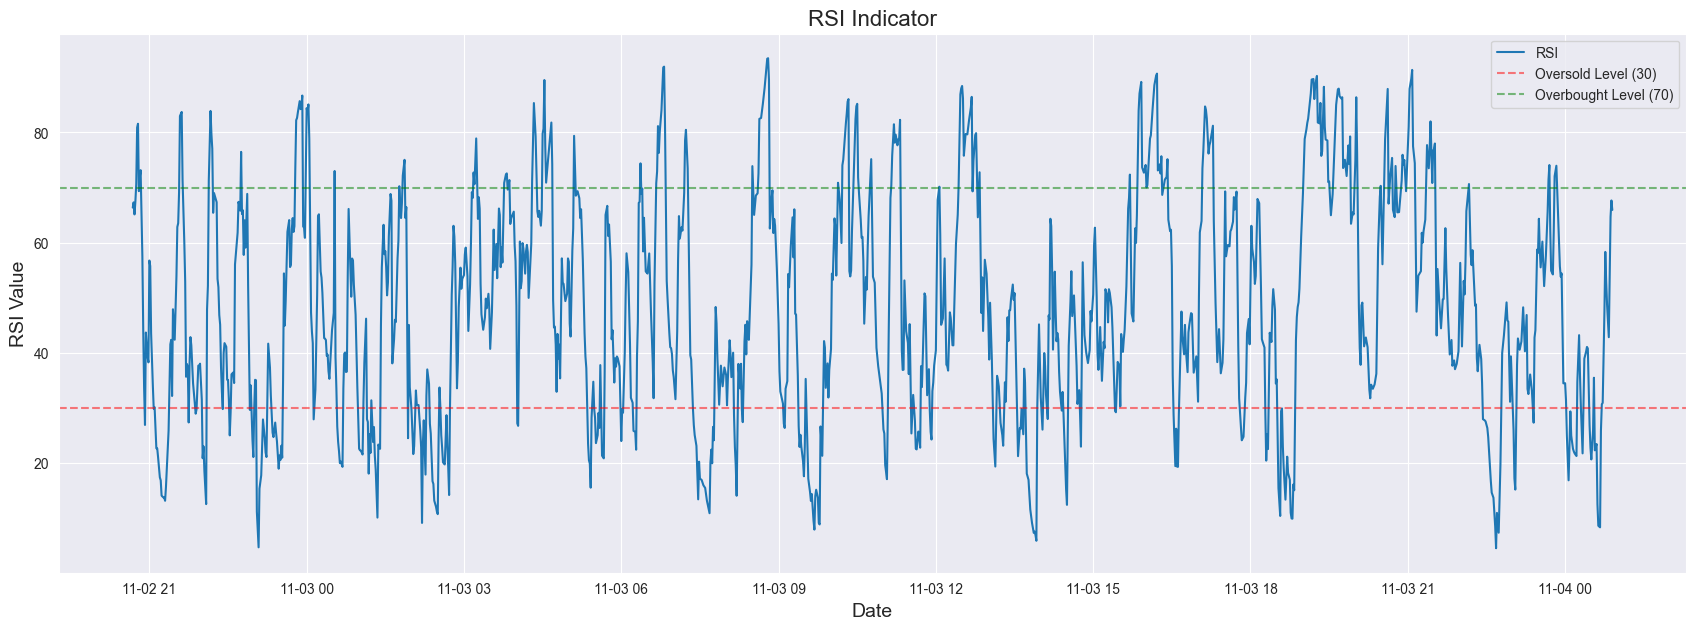

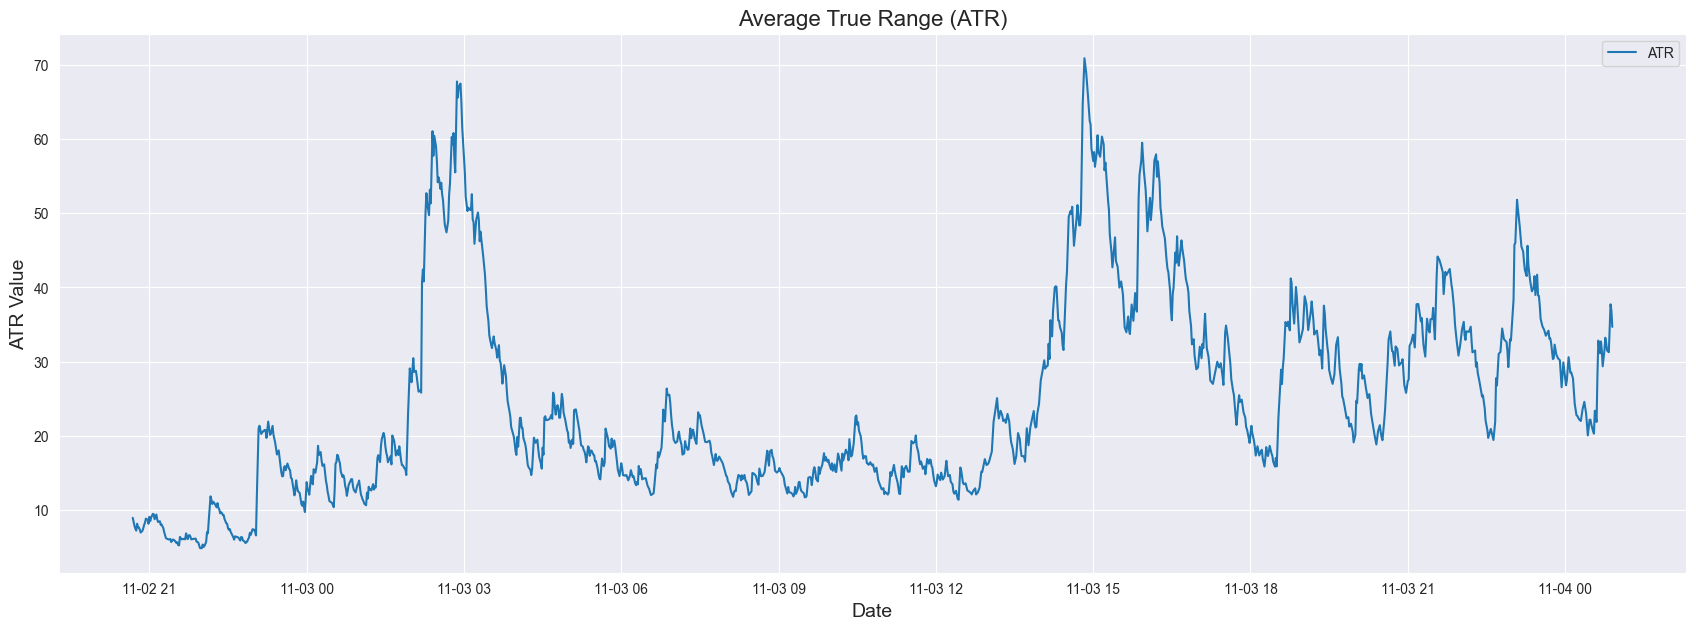

In [3]:
plot_ema_and_sma(processed_data)
plot_bollinger_bands(processed_data)
plot_rsi(processed_data)
plot_atr(processed_data)

In [4]:
data_with_signals = strategy.generate_buy_signals(processed_data)

Signals : [0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, -1, 0, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1,

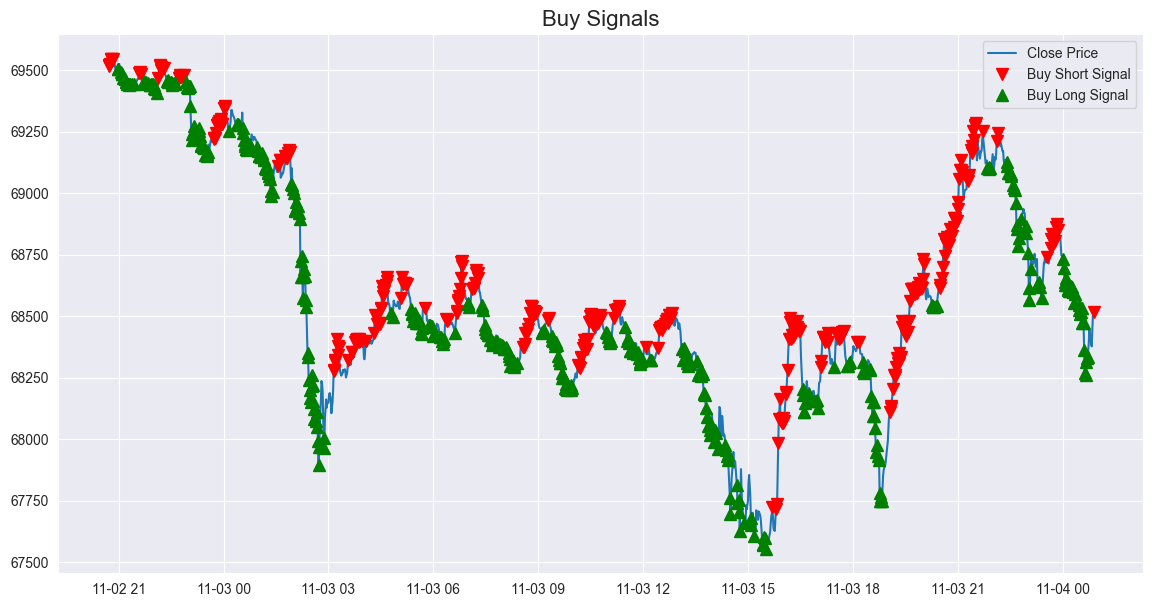

In [5]:
print("Signals :", data_with_signals["Signal"].tolist())
plot_signals(processed_data)

In [6]:
# transactions, equity_curve, dates = execute_trades(
#     data=data_with_signals,
#     initial_cash=initial_cash,
#     transaction_cost=transaction_cost,
#     leverage=leverage,
#     slippage_pct=slippage_pct,
#     risk_per_trade=risk_per_trade,
# )

from software.executor import TradingExecutor
from tqdm import tqdm

executor = TradingExecutor(
    initial_cash=initial_cash,
    transaction_cost=transaction_cost,
    leverage=leverage,
    slippage_pct=slippage_pct,
    risk_per_trade=risk_per_trade,
)

transactions = []
equity_curve = []
dates = []

print("Executor :", executor.__dict__)

Executor : {'cash': 1000, 'transaction_cost': 0.001, 'leverage': 1, 'slippage_pct': 0.0005, 'risk_per_trade': 0.02, 'positions': [], 'history': []}


In [7]:
for index, row in tqdm(
    data_with_signals.iterrows(),
    total=len(data_with_signals),
    desc="Executing trades",
):
    signal = row["Signal"]
    price = row["Close"]
    atr_stop_loss = row["ATR"] * 2

    date = index

    executor.execute_signal(
        signal,
        price,
        atr_stop_loss,
        date,
    )
    executor.update_positions(price, date, atr_stop_loss)

    if executor.history and (
        not transactions or executor.history[-1] != transactions[-1]
    ):
        last_transaction = executor.history[-1]
        transactions.append(last_transaction)

    total_value = executor.get_total_portfolio_value(price)
    equity_curve.append(total_value)
    dates.append(date)

Executing trades: 100%|██████████████████| 1225/1225 [00:00<00:00, 32317.45it/s]

Stop loss price:  69533.46983426629
Size in USDT:  861.6345471274767
Amount:  0.01240064028420674 BTC/USDT
======= Position opened at:  69483.06921093751 =======
Stop loss price:  69561.40370999843
Size in USDT:  868.1428617089076
Amount:  0.012489225644938881 BTC/USDT
======= Position opened at:  69511.34412890625 =======
Stop loss price:  69502.00551104495
Size in USDT:  914.7897117476946
Amount:  0.013171048851832632 BTC/USDT
======= Position opened at:  69454.5834609375 =======
Stop loss price:  69486.36611930802
Size in USDT:  833.904475383755
Amount:  0.012009961869737509 BTC/USDT
======= Position opened at:  69434.39824609376 =======
Stop loss price:  69539.80718676666
Size in USDT:  755.0458161279681
Amount:  0.010866730571456233 BTC/USDT
======= Position opened at:  69482.33520312501 =======
Stop loss price:  69485.82983053634
Size in USDT:  915.6916453876404
Amount:  0.013187090417105805 BTC/USDT
======= Position opened at:  69438.48994921875 =======
Stop loss price:  69249.1

In [8]:
print("Transactions :", transactions)
print("Equity curve :", equity_curve)
print("Dates :", dates)



Transactions : [{'action': 'open', 'position_type': 'short', 'price': 69483.06921093751, 'amount': 0.01240064028420674, 'date': Timestamp('2024-11-02 20:43:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'short', 'price': 69509.571578125, 'amount': 0.01240064028420674, 'date': Timestamp('2024-11-02 20:46:00+0000', tz='UTC'), 'pnl': -0.3286463221720908}, {'action': 'open', 'position_type': 'short', 'price': 69511.34412890625, 'amount': 0.012489225644938881, 'date': Timestamp('2024-11-02 20:47:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'short', 'price': 69433.54710937501, 'amount': 0.012489225644938881, 'date': Timestamp('2024-11-02 21:34:00+0000', tz='UTC'), 'pnl': 0.97162453142934}, {'action': 'open', 'position_type': 'short', 'price': 69454.5834609375, 'amount': 0.013171048851832632, 'date': Timestamp('2024-11-02 21:35:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'short', 'price': 69397.97896484376, 'amount': 0.013171048851832632, 'date': Times

In [9]:
performance_metrics = evaluate_performance(
    transactions, equity_curve, initial_cash
)

final_portfolio_value = equity_curve[-1]
total_profit = final_portfolio_value - initial_cash
print(f"Total Profit: ${total_profit:.2f}")

Total Profit: $-4.19


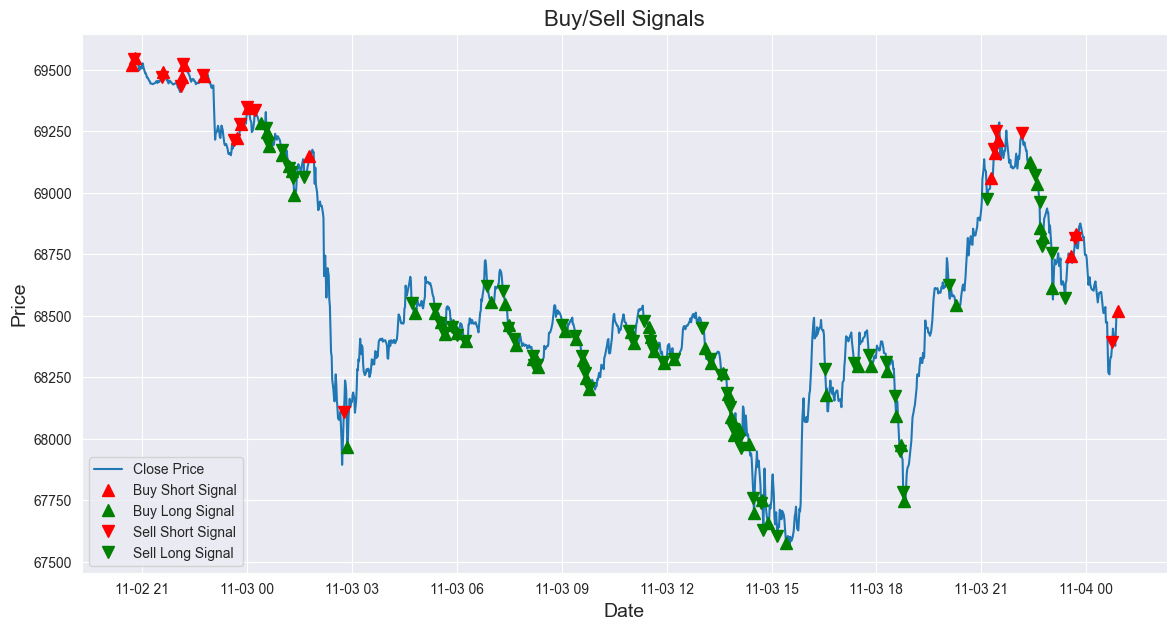

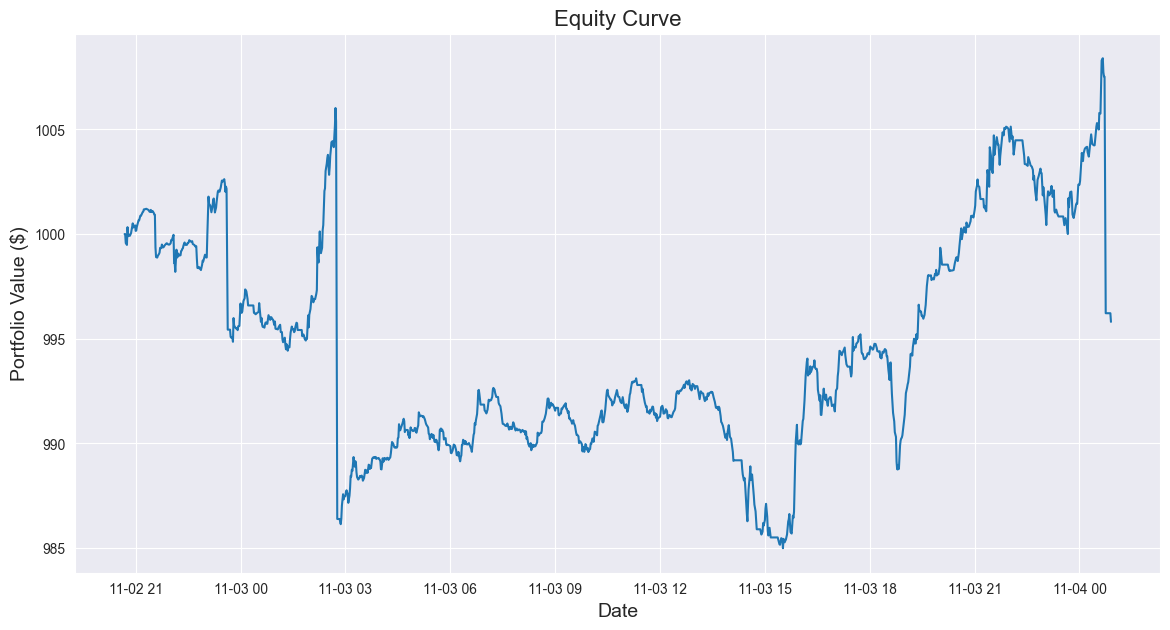

In [10]:
from software.plotter import plot_trades, plot_equity_curve

plot_trades(price_data=processed_data, transactions=transactions)
plot_equity_curve(dates, equity_curve)

- Add stop-loss strategy file and function.
- Add take-profit.
- Add partial take-profit.
- Limit the number of opposite positions to 1.
- Adjust the slippage.
- Add percentage of success trades.